# Generating Weekday and Weekend profiles

In [1]:
import polars as pl
import glob
import numpy as np
import matplotlib.pyplot as plt
import logging
import re
import os
from importlib import reload
import pandas as pd
import cluster_statistics_kMed
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    return

In [2]:
dataset = "SWW"    # Options: "SWW", "GroupE"
building_type = "house" # "flat" or "house"
categorical_features = "technical" # "technical" or "sociodemographic"
number_of_clusters = 6
weighting_alpha = 0.25

In [6]:
pattern = (f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/SM_DATA_hourlyAveraged_normalized/*.csv')
file_paths = glob.glob(pattern)

n_timestamps = 96

data_list = []
filename_list = []

for file_path in file_paths:
    df = pl.read_csv(file_path)

    base = os.path.basename(file_path)        # z.B. "10030.csv"
    resid, _ = os.path.splitext(base)         # "10030"

    if len(df) != n_timestamps:
        continue

    values_array = (
        df["day_avg_bruttolastgang_kwh"]
        .to_numpy()
        .reshape((1, n_timestamps, 1))
    )
    data_list.append(values_array)
    filename_list.append(resid)

if data_list:
    data_3d = np.concatenate(data_list, axis=0)
    print(f"Shape of the 3D array: {data_3d.shape}")
    train_data = data_3d
else:
    train_data = None
    print("No matching files with correct length found.")

train_data = data_3d
n_samples = data_3d.shape[0]

Shape of the 3D array: (1481, 96, 1)


In [ ]:
# Load the Excel file
file_path = (f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/Survey_Data/Survey_Data.xlsx")

df = pd.read_excel(file_path, skiprows=4, nrows=1500, header=None,dtype={10: str})

cols_to_extract = [10, 142, 143, 144, 145, 146, 147, 148, 149, 150, 152, 154, 127, 129, 155, 131, 128, 156, 157, 158, 159, 160]
extracted_df = df.iloc[:, cols_to_extract]

# Assign your own headers
extracted_df.columns = ['resident_id', 'Building Type', 'Heating', 'Water Heating', 
                        'Solar Panels', 'Electric Vehicle', 'Heat Pump', 'Individual Electric Boiler', 
                        'Individual Washing Machine', 'Home Battery','Number of Residents',
                        'Number of Days at Home','Age','Education', 'Employment', 'Tenant Type',
                        'Income','DR scenario', 'DR heating', 'DR hot water', 'DR EV', 'DR appliances']

extracted_df_pl = pl.from_pandas(extracted_df)

total_rows = extracted_df_pl.height

# Count unique house_id values
unique_house_ids = extracted_df_pl["resident_id"].n_unique()

print(f"Total rows: {total_rows}")
print(f"Unique resident_id count: {unique_house_ids}")

if total_rows > unique_house_ids:
    print(f"There are {total_rows - unique_house_ids} duplicate resident_id entries.")
else:
    print("No duplicates found in resident_id column.")

Total rows: 1500
Unique resident_id count: 1500
No duplicates found in resident_id column.


In [10]:
#read the file according to the filenames extracted before

result_df = extracted_df
result_df = pl.from_pandas(result_df)
extracted_df = pl.from_pandas(extracted_df)

order_dict = {resident_id: i for i, resident_id in enumerate(filename_list)}
ordered_rows = [result_df.filter(pl.col("resident_id") == filename) for filename in filename_list]
ordered_result_df = pl.concat(ordered_rows)

#print(ordered_result_df['CH_id'].to_list()[:10])
#print(len(ordered_result_df))
#print(ordered_result_df)



In [11]:
from pandas.api.types import CategoricalDtype

if building_type == "house":
    # Load categorical column as pandas category
    category_df = ordered_result_df.select(['Building Type', 'Solar Panels', 'Electric Vehicle','Heating', 
                                            'Water Heating', 'Home Battery']).to_pandas().astype('category')
    
elif building_type == "flat":
    # Load categorical column as pandas category
    category_df = ordered_result_df.select(['Building Type', 'Individual Electric Boiler', 
                                            'Individual Washing Machine']).to_pandas().astype('category')

days_at_home_categories = ['No Information', '<25%', '25-50%', '>50-75%', '>75%']
building_type_categories = ['No Information', 'Flat', 'House']
heating_categories = ['No Information', 'Other', 'Heat Pump', 'Boiler']
water_heating_categories = ['No Information', 'Other', 'Heat Pump', 'Boiler']
solar_panels_categories = ['No Information', 'No', 'Yes']
electric_vehicle_categories = ['No Information', 'No', 'Yes']
number_of_days_at_home_categories = ['No Information', '0', '1', '2', '3', '4', '5', '6', '7']
home_battery_categories = ['No Information', 'No', 'Yes']
heat_pump_categories = ['No Information', 'No', 'Yes']

electric_boiler_categories = ['No Information', 'No', 'Yes']
washing_machine_categories = ['No Information', 'No', 'Yes']

building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
heating_cat_type = CategoricalDtype(categories=heating_categories, ordered=True)
water_heating_cat_type = CategoricalDtype(categories=water_heating_categories, ordered=True)
solar_cat_type = CategoricalDtype(categories=solar_panels_categories, ordered=True)
ev_cat_type = CategoricalDtype(categories=electric_vehicle_categories, ordered=True)
number_of_days_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)
home_battery_cat_type = CategoricalDtype(categories=home_battery_categories, ordered=True)
heat_pump_cat_type = CategoricalDtype(categories=heat_pump_categories, ordered=True)

electric_boiler_cat_type = CategoricalDtype(categories=electric_boiler_categories, ordered=False)
washing_machine_cat_type = CategoricalDtype(categories=washing_machine_categories, ordered=False)

if building_type == "house":
    category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
    category_df['Heating'] = category_df['Heating'].astype(heating_cat_type)
    category_df['Water Heating'] = category_df['Water Heating'].astype(water_heating_cat_type)
    category_df['Solar Panels'] = category_df['Solar Panels'].astype(solar_cat_type)
    category_df['Electric Vehicle'] = category_df['Electric Vehicle'].astype(ev_cat_type)
    category_df['Home Battery'] = category_df['Home Battery'].astype(home_battery_cat_type)
elif building_type == "flat":
    category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
    category_df['Individual Electric Boiler'] = category_df['Individual Electric Boiler'].astype(electric_boiler_cat_type)
    category_df['Individual Washing Machine'] = category_df['Individual Washing Machine'].astype(washing_machine_cat_type)

rows_to_keep_indices = []

exclude_building_type = building_type

if building_type == "house":
    exclude_building_type = "Flat"
elif building_type == "flat":
    exclude_building_type = "House"

for i, row in category_df.iterrows():
    # Check if 'No Information' NOT in any value of that row
    if "No Information" not in row.values:
        # Check if 'Flat' NOT in any value of that row
        if exclude_building_type not in row.values:
            rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])

#print(category_df.iloc[rows_to_keep_indices])

for col in category_df.columns:
    category_df[col] = category_df[col].cat.codes

# Convert to NumPy array
category_array = category_df.to_numpy()

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_df])

# Filter both arrays using the collected indices to keep
cleaned_combined_data = combined_data[rows_to_keep_indices]
time_series_numeric = time_series_numeric[rows_to_keep_indices]
combined_data = cleaned_combined_data

filename_list = [filename_list[i] for i in rows_to_keep_indices]

In [12]:
%%skip

from pandas.api.types import CategoricalDtype

# Load categorical column as pandas category
category_df = ordered_result_df.select(['Building Type','Tenant Type', 'Age', 'Income', 'Education', 
                                        'Employment', 'Number of Residents','Number of Days at Home']).to_pandas().astype('category')


#category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(str)

building_type_categories = ['No Information', 'Flat', 'House']
tenant_type_categories = ['Living in a cooperative', 'Tenant', 'Owner']
age_categories = ['18-35 years old', '36 - 50 years old', '51 - 65 years old', 'More than 65 years old']
income_categories = ['I prefer not to say', 'Less than 4,000', '4,000-5,999','6000-9999','10000 CHF or more' ]
education_categories = ['Mandatory school', 'Secondary degree (Apprenticeship, high school et commercial/general culture school)'
                        , 'Tertiary degree  (Superior school (ES), University/EPF, vocational university)']
employment_categories = ['Employed', 'Unemployed', 'Retired']
number_of_residents_categories = ['1', '2', '3', '4', '> 4']
number_of_days_at_home_categories = ['0', '1', '2', '3', '4', '5', '6', '7']

building_cat_type = CategoricalDtype(categories=building_type_categories, ordered=True)
tenant_cat_type = CategoricalDtype(categories=tenant_type_categories, ordered=True)
age_cat_type = CategoricalDtype(categories=age_categories, ordered=True)
income_cat_type = CategoricalDtype(categories=income_categories, ordered=True)
education_cat_type = CategoricalDtype(categories=education_categories, ordered=True)
employment_cat_type = CategoricalDtype(categories=employment_categories, ordered=True)
number_of_residents_cat_type = CategoricalDtype(categories=number_of_residents_categories, ordered=True)
number_of_days_at_home_cat_type = CategoricalDtype(categories=number_of_days_at_home_categories, ordered=True)

category_df['Building Type'] = category_df['Building Type'].astype(building_cat_type)
category_df['Tenant Type'] = category_df['Tenant Type'].astype(tenant_cat_type)
category_df['Age'] = category_df['Age'].astype(age_cat_type)
category_df['Income'] = category_df['Income'].astype(income_cat_type)
category_df['Education'] = category_df['Education'].astype(education_cat_type)
category_df['Employment'] = category_df['Employment'].astype(employment_cat_type)
category_df['Number of Residents'] = category_df['Number of Residents'].astype(number_of_residents_cat_type)
category_df['Number of Days at Home'] = category_df['Number of Days at Home'].astype(number_of_days_at_home_cat_type)

rows_to_keep_indices = []

for i, row in category_df.iterrows():
    # Check if 'No Information' NOT in any value of that row
    if "No Information" not in row.values:
        # Check if 'Flat' NOT in any value of that row
        if "Flat" not in row.values:
            rows_to_keep_indices.append(i)

category_df = category_df.drop(columns=['Building Type'])

for col in category_df.columns:
    category_df[col] = category_df[col].cat.codes

# Convert to NumPy array
category_array = category_df.to_numpy()

# Numeric time series shaped as (n_samples, n_timestamps)
time_series_numeric = data_3d[:, :, 0].reshape(n_samples, n_timestamps)

# Combine horizontally
combined_data = np.hstack([time_series_numeric, category_df])

# Filter both arrays using the collected indices to keep
cleaned_combined_data = combined_data[rows_to_keep_indices]
time_series_numeric = time_series_numeric[rows_to_keep_indices]
combined_data = cleaned_combined_data

filename_list = [filename_list[i] for i in rows_to_keep_indices]

In [13]:
# 5. Specify the categorical feature column indices (the last 3 columns)

if building_type == "house":
    number_of_categories = 5
else:
    number_of_categories = 2

categorical_indices = list(range(combined_data.shape[1] - number_of_categories, combined_data.shape[1]))
numerical_indices = list(range(0, combined_data.shape[1]-number_of_categories))

In [14]:
import numpy as np
from kmedoids import KMedoids
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import pdist, squareform, cdist
import gower

# Suppose data_3d shape = (n_samples, n_timestamps, n_features)
n_samples = combined_data.shape[0]
n_timestamps = 96

# Example: category_df is your pandas DataFrame with categorical columns
time_series_numeric = data_3d.squeeze(axis=2)      # (n_samples, n_timestamps)
time_series_numeric = time_series_numeric[rows_to_keep_indices]

# -- Compute categorical distance matrix (Hamming/fraction mismatches) --
#cat_dist_mat = gower.gower_matrix(combined_data[:,categorical_indices])
cat_dist_mat = squareform(pdist(combined_data[:,categorical_indices], metric='hamming'))
# -- Numeric distance matrix (Euclidean) --
num_dist_mat = pairwise_distances(time_series_numeric, metric='euclidean')

# -- Normalize distances to [0,1] --
num_dist_mat /= num_dist_mat.max() if num_dist_mat.max() > 0 else 1

# -- Combine with weight alpha --
alpha = weighting_alpha
combined_dist_mat = alpha * num_dist_mat + (1 - alpha) * cat_dist_mat


k = number_of_clusters
model = KMedoids(n_clusters=k, metric='precomputed', method='fasterpam', random_state=42)
model.fit(combined_dist_mat)
labels = model.labels_
medoids = model.medoid_indices_

clusters = labels +1

from sklearn.metrics import silhouette_score
sil_score = silhouette_score(combined_dist_mat, labels, metric='precomputed')
print(f'Silhouette score: {sil_score:.3f}')

Silhouette score: 0.412


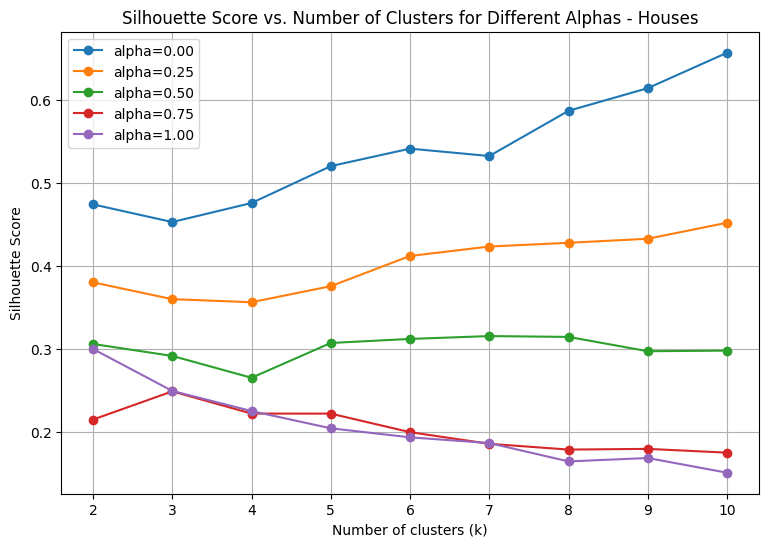

In [15]:
#%%skip

import numpy as np
import matplotlib.pyplot as plt
from kmedoids import KMedoids
from sklearn.metrics import silhouette_score, pairwise_distances


n_samples = combined_data.shape[0]

time_series_numeric = data_3d.squeeze(axis=2) 
time_series_numeric = time_series_numeric[rows_to_keep_indices]

cat_dist_mat = np.zeros((n_samples, n_samples))
num_dist_mat = pairwise_distances(time_series_numeric, metric='euclidean')
cat_dist_mat = squareform(pdist(combined_data[:,categorical_indices], metric='hamming'))

#cat_dist_mat /= cat_dist_mat.max() if cat_dist_mat.max() > 0 else 1
num_dist_mat /= num_dist_mat.max() if num_dist_mat.max() > 0 else 1

alphas = np.linspace(0.00, 1, 5)
k_values = range(2, 11)  

# Store silhouette scores in a (len(k_values), len(alphas)) array
silhouette_scores = np.zeros((len(k_values), len(alphas)))

for a_idx, alpha in enumerate(alphas):
    combined_dist_mat = alpha * num_dist_mat + (1 - alpha) * cat_dist_mat
    #combined_dist_mat = alpha*num_dist_mat + cat_dist_mat
    for k_idx, k in enumerate(k_values):
        model = KMedoids(n_clusters=k, metric="precomputed", method='fasterpam', random_state=42)
        model.fit(combined_dist_mat)
        labels = model.labels_
        sil_score = silhouette_score(combined_dist_mat, labels, metric="precomputed")
        silhouette_scores[k_idx, a_idx] = sil_score
        #print(f"k={k}, alpha={alpha:.2f}, silhouette={sil_score:.3f}")

plt.figure(figsize=(9, 6))
for a_idx, alpha in enumerate(alphas):
    plt.plot(list(k_values), silhouette_scores[:, a_idx], marker='o', label=f'alpha={alpha:.2f}')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title(f'Silhouette Score vs. Number of Clusters for Different Alphas - {building_type.capitalize()}s')
plt.legend()
plt.grid(True)
plt.savefig(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/kMedoids_SC_{building_type}.png')
plt.show()

In [20]:
# saves the found clusters in a csv file with the corresponding household IDs

# Convert filename_list items to strings
resident_ids = [str(h) for h in filename_list]

# Creates Polars DataFrame with house IDs and clusters
result_df = pl.DataFrame({
    "resident_id": resident_ids,
    "cluster": clusters
}).sort("cluster")

result_df.write_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kMed_{building_type}.csv")

Cluster 1 size: 76
Cluster 2 size: 73
Cluster 3 size: 125
Cluster 4 size: 69
Cluster 5 size: 65
Cluster 6 size: 64


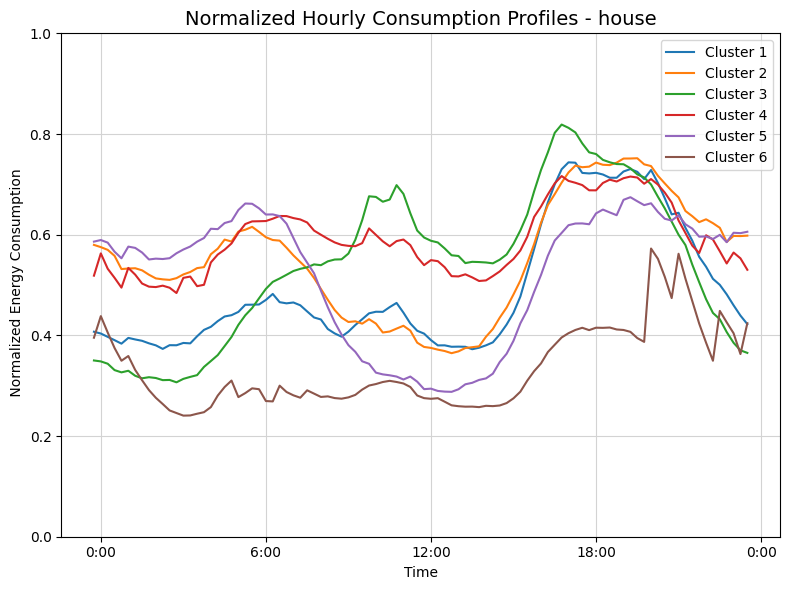

In [21]:
unique_clusters = np.unique(clusters)

labels = ['0:00','6:00','12:00','18:00','0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

plt.figure(figsize=(8, 6))
for cl in unique_clusters:
    idx = np.where(clusters == cl)[0]
    avg_profile = time_series_numeric[idx].mean(axis=0)
    plt.plot(avg_profile, label=f'Cluster {cl}')
    print(f'Cluster {cl} size: {len(idx)}')

plt.title(f"Normalized Hourly Consumption Profiles - {building_type}", fontsize=14)
plt.xlabel("Time")
plt.ylabel(" Normalized Energy Consumption")
plt.ylim(0,1)
#plt.xticks(range(1,108,12),labels=labels)
plt.xticks(range(1,120,24),labels=labels)
plt.tight_layout()
#plt.legend()
#plt.margins(0)
plt.grid(True, color = 'lightgray')
plt.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=1,
    fontsize='medium'
)
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/HourlyAveraged_KMed_{building_type}.png",
    bbox_inches='tight'
    )
plt.show()



(472, 96, 1)


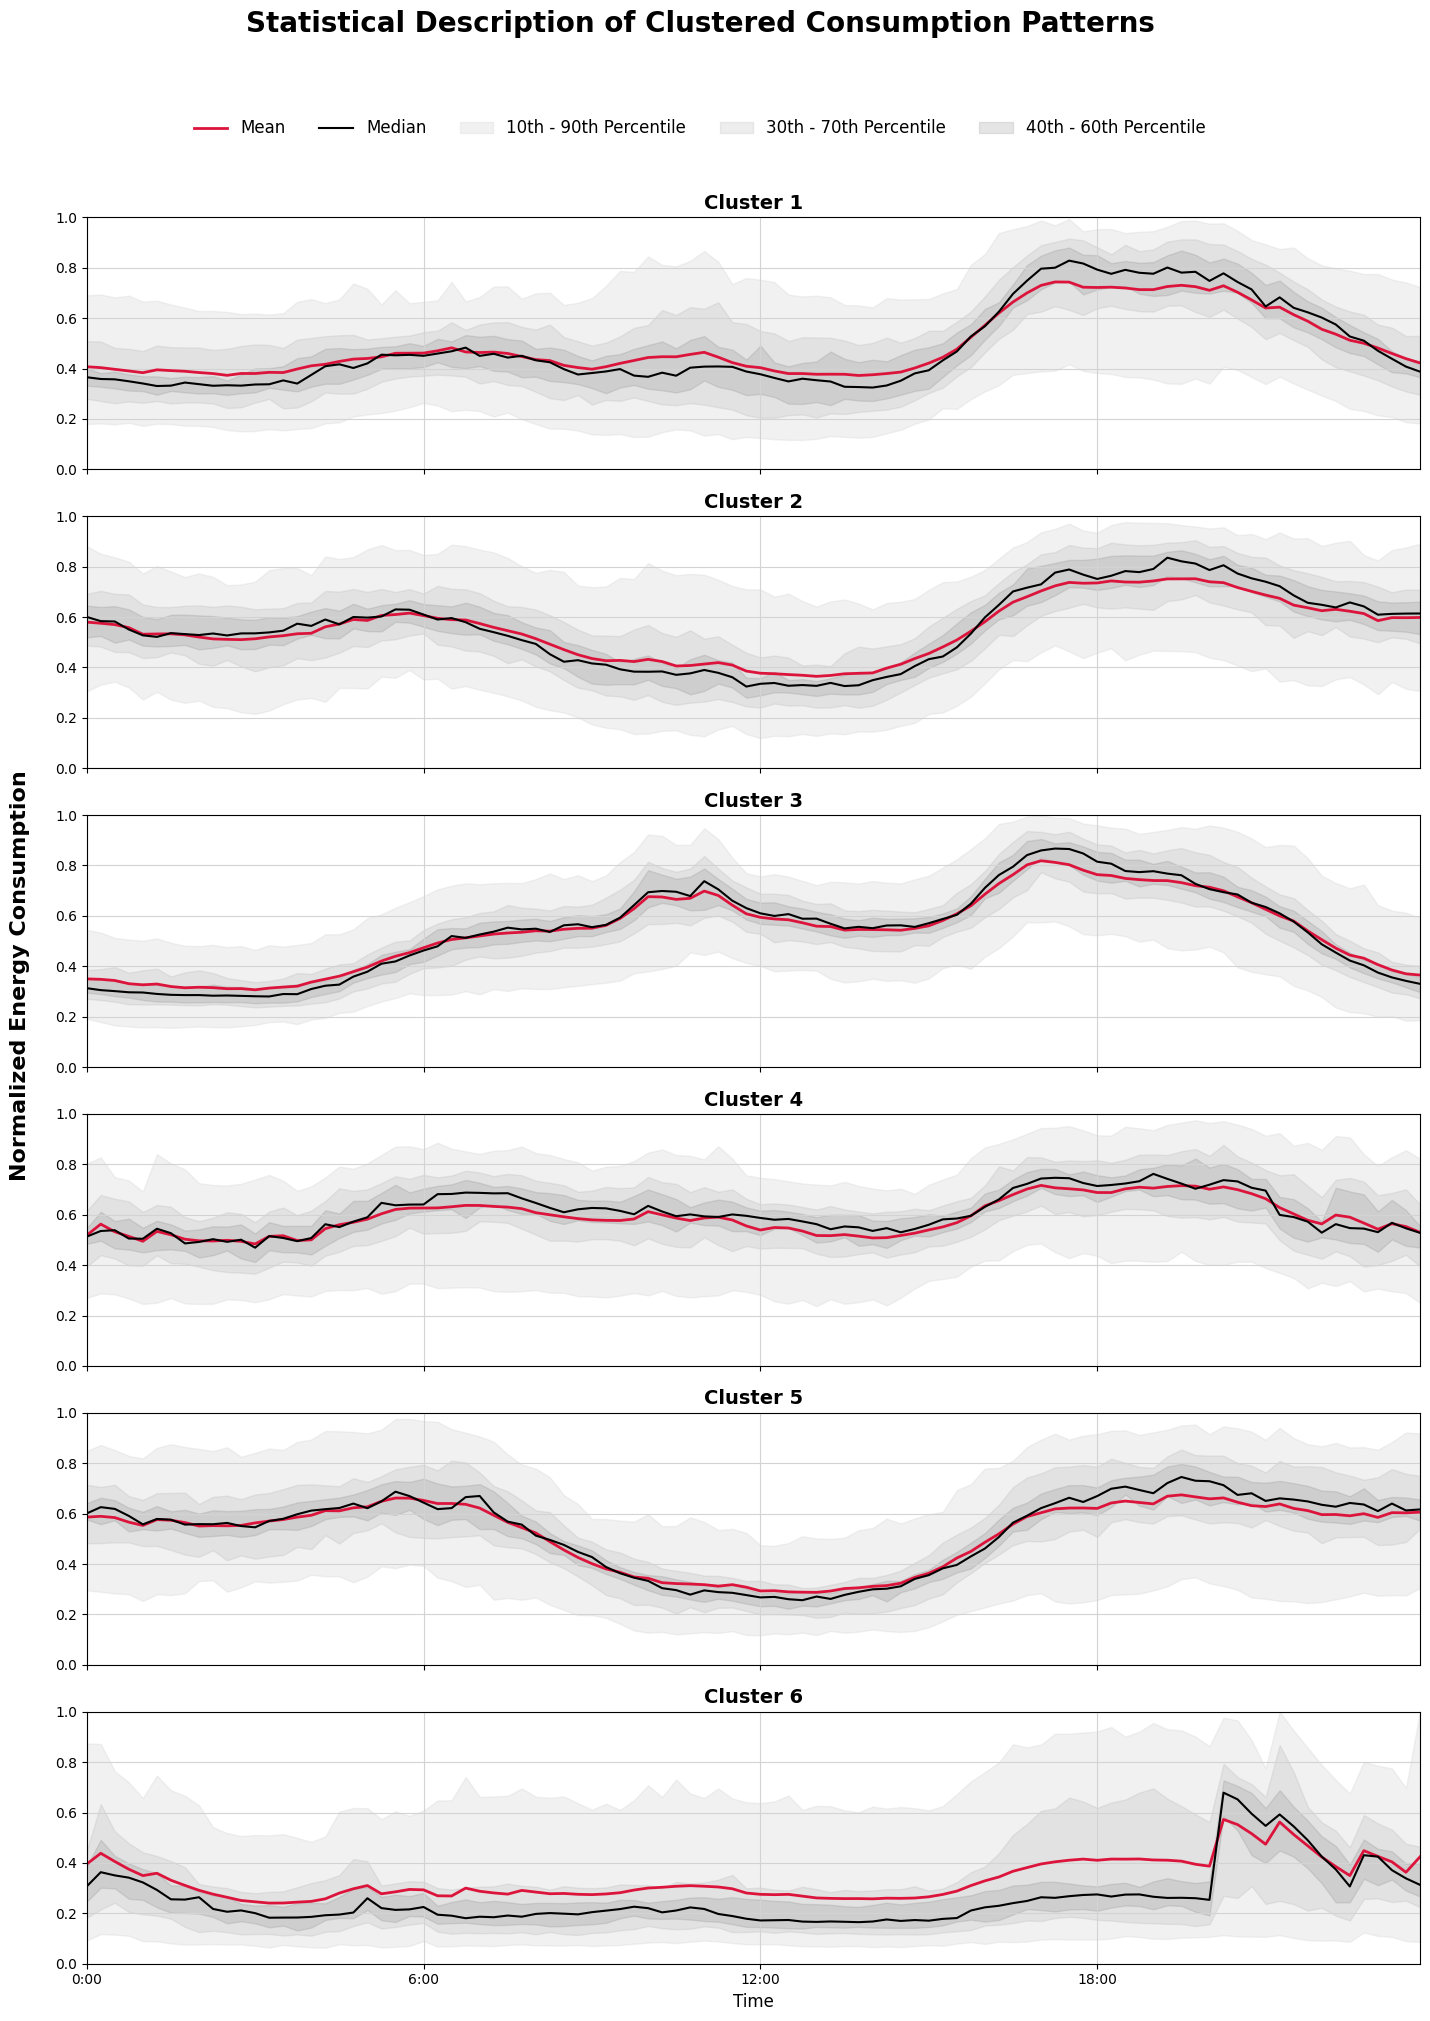

In [22]:
reload(cluster_statistics_kMed)

from cluster_statistics_kMed import plot_cluster_percentiles

data_3d_kProt = np.expand_dims(time_series_numeric, axis=-1)

print(data_3d_kProt.shape)

#print(data_3d_kProt)

for i in range(number_of_clusters):

    i = i+1
    # Select samples for the current cluster
    cluster_data = time_series_numeric[clusters == i]
    
    if cluster_data.shape[0] == 0:
        print(f"Warning: cluster {i} is empty, skipping.")
        continue  # Skip this cluster

plot_cluster_percentiles(data_3d_kProt,clusters,number_of_clusters, building_type, dataset)

In [23]:
result_df = pl.read_csv(f'/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/DATA/Cluster/hourly_avg_clustering_kMed_{building_type}.csv')

# Read the alle_mittelwerte file
alle_mittelwerte_df = pl.read_csv(f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/DATA/{dataset}/alle_mittelwerte.csv") 

# Normalize keys in all DataFrames for clean join
result_df = result_df.with_columns(
    pl.col("resident_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

alle_mittelwerte_df = alle_mittelwerte_df.with_columns(
    pl.col("file_id")
      .cast(pl.Utf8)
      .str.strip_chars()
      .str.to_lowercase()
      .alias("resident_id")
)

result_df = result_df.join(
    alle_mittelwerte_df.select([
        "resident_id",
        "bruttolastgang_kwh_sum",
        "average_daily_consumption",
        "average_hourly_consumption",
        "bruttolastgang_kwh_max"
    ]),
    on="resident_id",
    how="left"
)
result_df = result_df.select([
    "resident_id",
    "cluster",
    "bruttolastgang_kwh_sum",
    "average_daily_consumption" ,
    "average_hourly_consumption",
    "bruttolastgang_kwh_max"
])

cluster_summary = result_df.group_by("cluster").agg([
    pl.count("resident_id").alias("num_households"),
    pl.mean("bruttolastgang_kwh_sum").alias("avg_total_consumption [kWh]").round(2),
    pl.mean("average_daily_consumption").alias("avg_daily_consumption [kWh]").round(2),
    pl.mean("average_hourly_consumption").alias("avg_hourly_consumption [kWh]").round(2),
    pl.mean("bruttolastgang_kwh_max").alias("avg_max_consumption [kWh]").round(2)
    
]).sort("cluster")

cluster_summary = cluster_summary.with_columns([
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households")/1000)
        .alias("combined_max_consumption [MWh]")
        .round(2),
    (pl.col("avg_total_consumption [kWh]") * pl.col("num_households"))
        .alias("cluster_total_consumption [kWh]"),
])

cluster_summary = cluster_summary.with_columns([
    (pl.col("num_households") / pl.col("num_households").sum())
        .alias("share_of_households")
        .round(2),
    (pl.col("cluster_total_consumption [kWh]") 
     / pl.col("cluster_total_consumption [kWh]").sum())
        .alias("share_of_total_consumption")
        .round(2),
])

print(cluster_summary)

shape: (6, 10)
┌─────────┬────────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
│ cluster ┆ num_househ ┆ avg_total ┆ avg_daily ┆ … ┆ combined_ ┆ cluster_t ┆ share_of_ ┆ share_of_ │
│ ---     ┆ olds       ┆ _consumpt ┆ _consumpt ┆   ┆ max_consu ┆ otal_cons ┆ household ┆ total_con │
│ i64     ┆ ---        ┆ ion [kWh] ┆ ion [kWh] ┆   ┆ mption    ┆ umption   ┆ s         ┆ sumption  │
│         ┆ u32        ┆ ---       ┆ ---       ┆   ┆ [MWh]     ┆ [kWh…     ┆ ---       ┆ ---       │
│         ┆            ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ f64       ┆ f64       │
│         ┆            ┆           ┆           ┆   ┆ f64       ┆ f64       ┆           ┆           │
╞═════════╪════════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
│ 1       ┆ 76         ┆ 5775.13   ┆ 8.83      ┆ … ┆ 438.91    ┆ 438909.88 ┆ 0.16      ┆ 0.12      │
│ 2       ┆ 73         ┆ 10582.28  ┆ 16.57     ┆ … ┆ 772.51    ┆ 772506.44 ┆

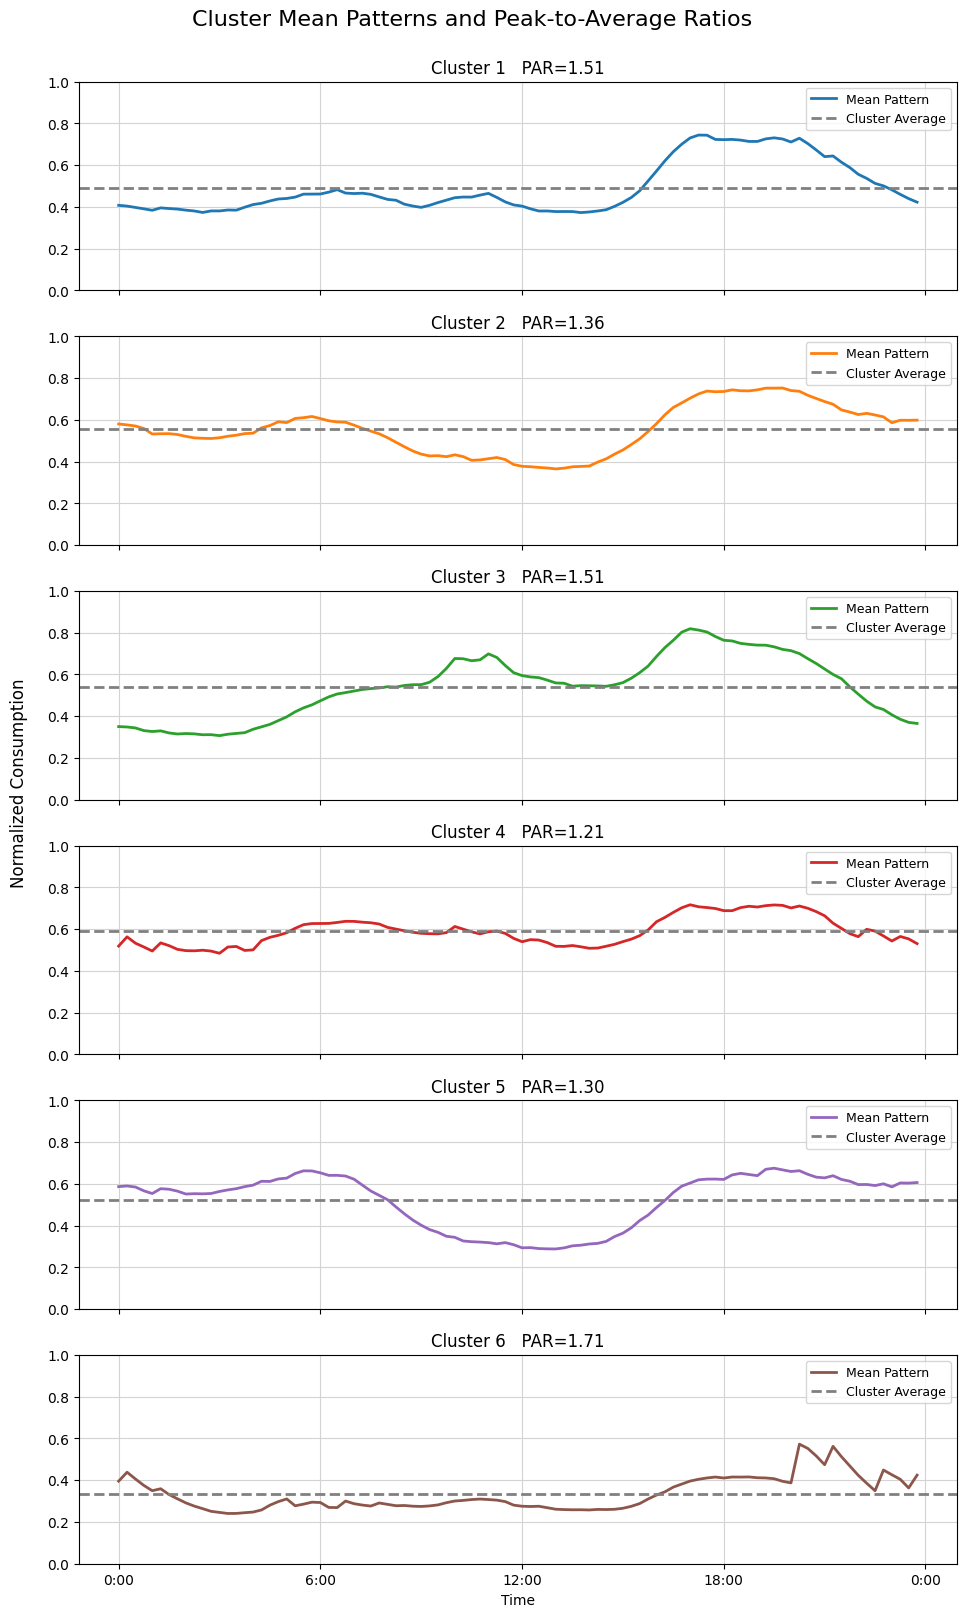

In [24]:
labels = ['0:00', '6:00', '12:00', '18:00', '0:00']
colors= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728','#9467bd', '#8c564b']

n_clusters_to_plot = np.unique(clusters)
n_clusters = len(n_clusters_to_plot)

fig, axes = plt.subplots(n_clusters, 1, figsize=(10, 2.8 * n_clusters), sharex=True)

if n_clusters == 1:
    axes = [axes]

for idx, cl in enumerate(sorted(n_clusters_to_plot)):  # Cluster 1 oben
    cluster_idx = np.where(clusters == cl)[0]
    mean_time_series = time_series_numeric[cluster_idx].mean(axis=0)
    PAR_average = np.mean(mean_time_series)
    PAR_max = np.max(mean_time_series)

    ax = axes[idx]
    ax.plot(range(1,97), mean_time_series.ravel()[:96],
            label='Mean Pattern', linewidth=2, color=colors[cl-1])
    ax.axhline(PAR_average, color='grey', linestyle='--', linewidth=2, label='Cluster Average')
    ax.set_title(f"Cluster {cl}   PAR={PAR_max/PAR_average:.2f}",
                 loc='center', fontsize=12, color='black')
    ax.set_ylim(0, 1)
    ax.set_yticks(np.linspace(0, 1, 6))
    ax.grid(color='lightgray', zorder=0)
    ax.legend(fontsize=9)
    if idx == n_clusters-1:
        ax.set_xlabel("Time")
        ax.set_xticks(range(1,120,24))
        ax.set_xticklabels(labels)
    else:
        ax.set_xticks([])  # Keine X-Ticks für die oberen Subplots
    # ACHTUNG: Kein ax.set_ylabel() hier!

fig.suptitle("Cluster Mean Patterns and Peak-to-Average Ratios", fontsize=16,  y=0.96)
fig.text(0.038, 0.5, "Normalized Consumption", va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0.06, 0, 1, 0.96])
plt.savefig(
    f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Cluster/PAR_KMed_{building_type}.png",
    bbox_inches='tight'
)
plt.show()

In [25]:
# Create DataFrame with cluster labels and decoded categorical feature

if building_type == "flat":
    df = pd.DataFrame({
        'cluster': clusters,
        'Individual Electric Boiler': [electric_boiler_categories[int(code)] for code in combined_data[:, -2]],
        'Individual Washing Machine': [washing_machine_categories[int(code)] for code in combined_data[:, -1]]
    })
    

else:  
    df = pd.DataFrame({
        'cluster': clusters,
        'Solar Panels': [solar_panels_categories[int(code)] for code in combined_data[:, -5]],
        'Electric Vehicle': [electric_vehicle_categories[int(code)] for code in combined_data[:, -4]],
        'Heating': [heating_categories[int(code)] for code in combined_data[:, -3]],
        'Water Heating': [water_heating_categories[int(code)] for code in combined_data[:, -2]],
        'Home Battery': [home_battery_categories[int(code)] for code in combined_data[:, -1]]
    })

print(df.head())

   cluster Solar Panels Electric Vehicle    Heating Water Heating Home Battery
0        6           No               No      Other        Boiler           No
1        3           No               No      Other         Other           No
2        3           No               No      Other         Other           No
3        4           No               No  Heat Pump     Heat Pump           No
4        4           No               No     Boiler     Heat Pump           No


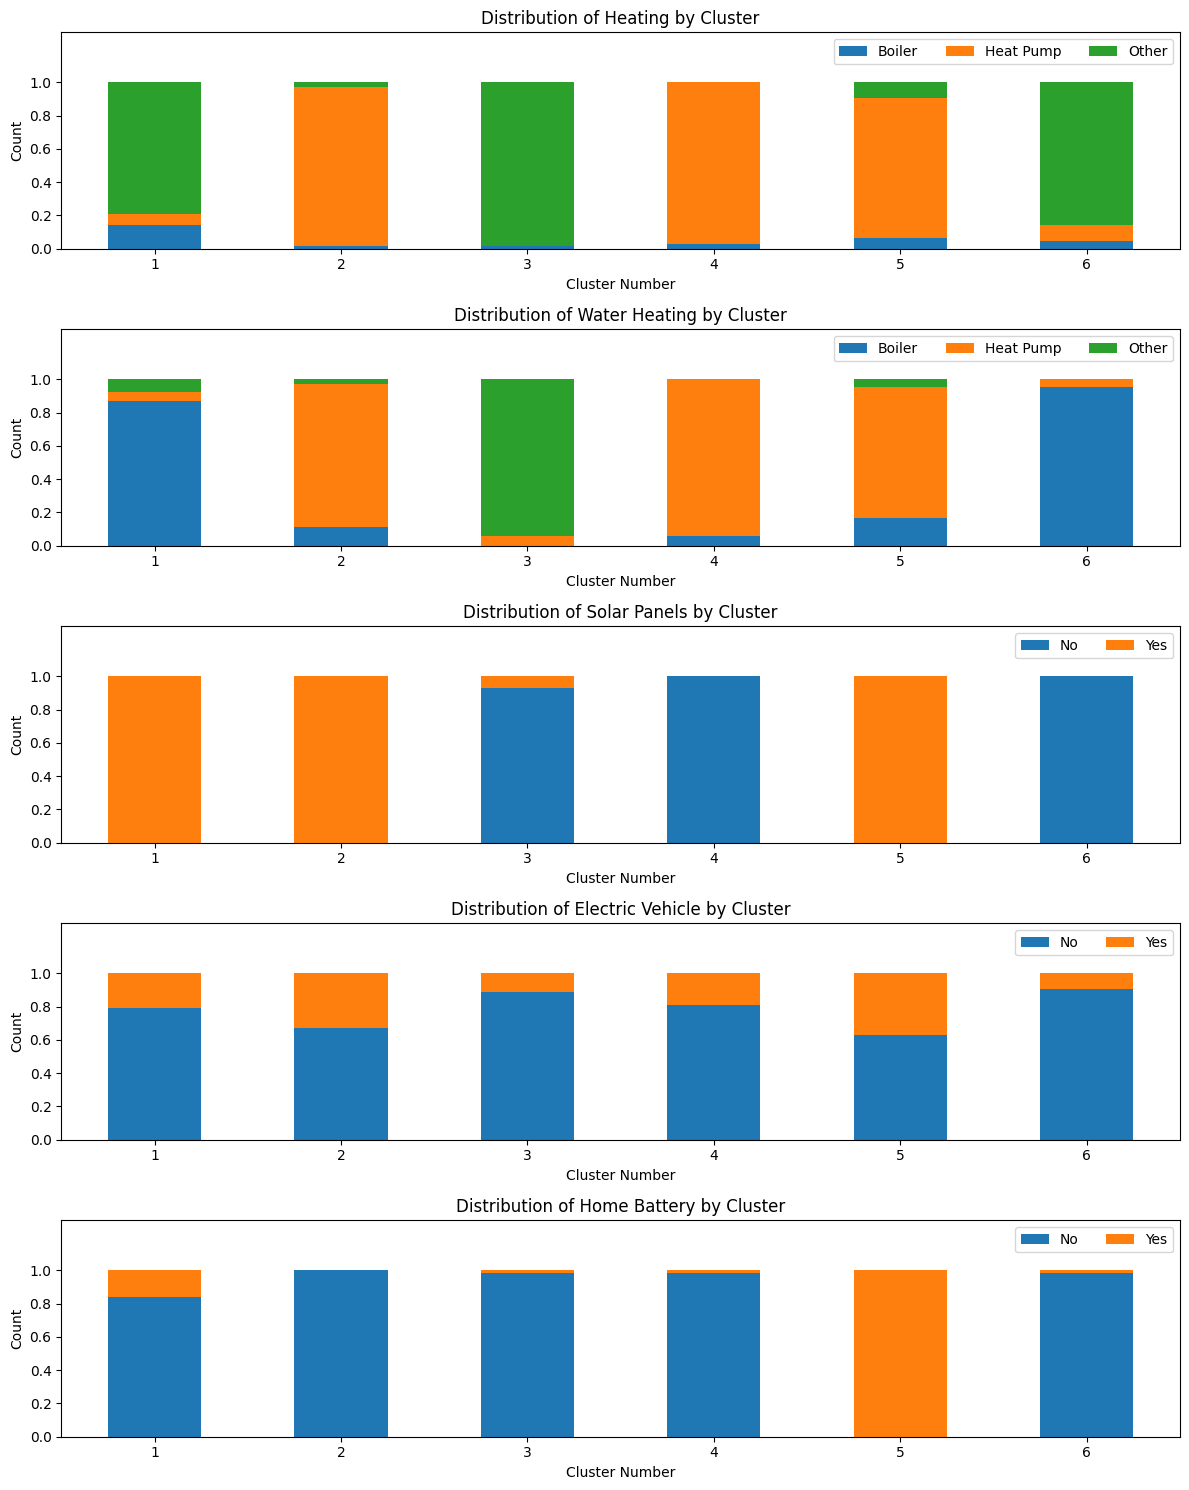

In [26]:
# Number of categorical features to plot

if building_type == "flat":
    category_features = ['Individual Electric Boiler', 'Individual Washing Machine']
    n_features = len(category_features)
else:
    category_features = ['Heating', 'Water Heating', 'Solar Panels', 'Electric Vehicle', 'Home Battery']
    n_features = len(category_features)

fig, axes = plt.subplots(n_features, 1, figsize=(12, 3 * n_features))

if n_features == 1:
    axes = [axes]

for i, feature in enumerate(category_features):
    ax = axes[i]
    # Group and pivot data for plotting
    counts = df.groupby(['cluster', feature]).size().unstack(fill_value=0)
    proportions = counts.div(counts.sum(axis=1), axis=0)
    
    # Plot stacked bar chart
    proportions.plot(kind='bar', stacked=True, ax=ax)
    
    # Titles and labels
    ax.set_title(f'Distribution of {feature} by Cluster')
    ax.set_ylabel('Count')
    ax.set_xlabel('Cluster Number')
    ax.set_ylim(0, 1.3)  # y-axis goes only up to 1.15 (bars max out at 1, extra space for DR titles)
    ax.set_yticks(np.arange(0, 1.01, 0.2))
    
    # Rotate x-ticks for readability
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.legend(
    #title='Category',
    loc='upper right',
    bbox_to_anchor=(1, 1),  # Adjust this value for vertical position
    ncol=8,
    fontsize='medium'
)
#plt.savefig(
#f"/Users/jansigrist/Documents/SP/Customer_Segmentation_Lantern/Results/{dataset}/Plots/Survey/categories_tech_house.png",
#bbox_inches='tight'
#)
plt.tight_layout()
plt.show()